In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import os
import numpy as np
from config import YOLO_BEST_PT,OUTPUT_DIR

Model = YOLO(YOLO_BEST_PT)
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

face_mesh=mp_face_mesh.FaceMesh(
            min_detection_confidence=0.2,
            min_tracking_confidence=0.2)

In [2]:
from ToothClassifier import ToothClassifier

class SMILE:
    def __init__(self,input_path, device='cpu',filter=0.9):
        self.device=device
        #####Input/output#####
        self.input_path=input_path 

        self.output_path=f"{OUTPUT_DIR}output.jpeg" 
        """圖片輸出路徑"""



        #####Image normalize#####
        img=cv2.imread(input_path)
        h, w ,d= img.shape
        self.img=cv2.resize(img, (1024, int(1024*h/w)), interpolation=cv2.INTER_AREA)
        self.shape=self.img.shape
        """原圖shape"""

        #####Find mouse#####
        self.mouse=[]
        self.box=[]
        """嘴巴Box"""
        self.boximg=[]
        """裁切只保留嘴巴img"""
        self.box_pol=[]
        """boximg切割的座標"""
        


        #####Result#####
        self.filter=filter
        self.tooth=[]
        """
        [center_x,center_y,w,h]
        """
        self.tooth_cls=[]
        """牙齒類別"""

        self.ntooth=0
        """牙齒數"""


        #### set_model###


        pass


    def find_all_tooth(self):
        try:
            self.find_mouse()
        except:
            return False

        result = Model.predict(
            source=self.output_path,
            mode="predict",
            device=self.device
        )
        
        



        boxes = result[0].boxes
        
        self.tooth=[]
        for box in boxes:
            if box.conf[0]>=self.filter:
                self.tooth.append(box.xywh.tolist()[0] )



        h,w,d=self.boximg.shape

        self.tooth_cls=ToothClassifier(w,h,self.tooth).cls

        self.ntooth=len(self.tooth_cls)


        
        # OUTPUT
        currentAxis = plt.gca()
        img=plt.imread(self.output_path)
        plt.imshow(img)

        colors=plt.cm.hsv(np.linspace(0, 1, self.ntooth)).tolist()   


        for t, cl,c in zip(self.tooth, self.tooth_cls,colors):
            x,y,w,h=tuple(t)
            
            plt.scatter(x,y)
            currentAxis.text(x,y, cl,bbox={'facecolor': c, 'alpha': 0.5})
            currentAxis.add_patch(plt.Rectangle((x-w/2,y-h/2),w,h,fill=False,edgecolor=c,linewidth=2))


        plt.axis('off')        
        plt.savefig(self.output_path,bbox_inches='tight',pad_inches=0.0, dpi=200)
        #plt.show()
        plt.clf()
        return True


    
    
    def find_mouse(self): # 裁切嘴巴區域，存到 output_path
        h, w, d = self.img.shape
        
    
        mouse=[62,96,89,179,86,15,316,403,319,325,292,407,272,271,268,12,38,41,42,183]#嘴巴
        lip=[78,95,88,178,87,14,317,402,318,324,308,415,310,311,312,13,82,81,80,191]#嘴唇
    
        #########################openCV辨識嘴 #########################
        RGBim = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(RGBim)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                #for index in mouse:
                for index in lip:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    self.mouse.append([x,y])
        
        

        self.mouse=np.array(self.mouse)

        umos=min(self.mouse[:,1])#嘴上緣
        dmos=max(self.mouse[:,1])#嘴下緣
        lmos=min(self.mouse[:,0])#嘴左緣
        rmos=max(self.mouse[:,0])#嘴右緣
        wmos=rmos-lmos#嘴寬
        hmos=dmos-umos#嘴高
        mmos=[int((lmos+rmos)/2),int((umos+dmos)/2)]#嘴中心

        
        
        ######輸出#####
        self.box=np.array([lmos,rmos,umos,dmos])
    

        self.boximg=self.img[self.box[2]-5:self.box[3]+5,self.box[0]-5:self.box[1]+5]

        self.box_pol=[self.box[0]-5,self.box[2]-5]


        cv2.imwrite(self.output_path,self.boximg)
        

        return self.box
    
    



image 1/1 c:\gits\SMILE_tmp\output\output.jpeg: 160x640 19 teeths, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 160, 640)


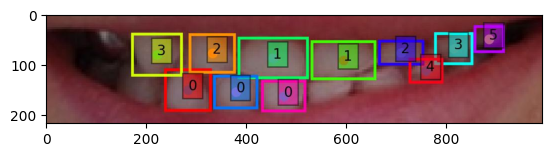

In [7]:
from config import TEST_IMG

smile=SMILE(TEST_IMG, device='cuda')
import matplotlib.pyplot as plt

smile.find_all_tooth()

img=plt.imread('output\output.jpeg')
plt.imshow(img)

plt.show()